In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import akshare as ak
import datetime
from matplotlib.ticker import PercentFormatter

# 设置中文字体和解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号 '-' 显示为方块的问题 

In [ ]:
def get_stock_data(stock_code, start_date, end_date):
    if stock_code.startswith(('sh', 'sz')):  # 沪深指数
        df = ak.stock_zh_index_daily(symbol=stock_code)
    else:  # A股个股
        df = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date, adjust="qfq")

    column_mapping = {
        '日期': 'date',
        '收盘': 'close',
        'open': 'open',
        'high': 'high',
        'low': 'low'
    }
    df.rename(columns=column_mapping, inplace=True)

    if 'date' not in df.columns or 'close' not in df.columns:
        raise ValueError(f"缺失必要列，当前列：{df.columns.tolist()}")
        
    df.index = pd.to_datetime(df['date'])
    
    # 统一在此处对所有数据源进行日期筛选
    df = df.loc[start_date:end_date]
    
    return df[['close']].rename(columns={'close': stock_code})


# 计算每日收益率
def calculate_returns(prices: pd.DataFrame) -> pd.DataFrame:
    returns = prices.pct_change().dropna()
    return returns

# 年化收益率
def annualized_return(returns, periods_per_year=252):
    return (1 + returns).prod() ** (periods_per_year / len(returns)) - 1

# 年化波动率
def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

# 夏普比率
def sharpe_ratio(returns, risk_free_rate=0.03, periods_per_year=252):
    excess_return = returns.mean() * periods_per_year - risk_free_rate
    vol = annualized_volatility(returns, periods_per_year)
    return excess_return / vol if vol != 0 else np.nan

def sortino_ratio(returns, risk_free_rate=0.03, periods_per_year=252):
    # 计算年化超额收益
    excess_return = returns.mean() * periods_per_year - risk_free_rate
    # 只保留负收益部分计算下行波动率
    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(periods_per_year)
    # 防止除以零
    if downside_deviation == 0:
        return np.nan
    return excess_return / downside_deviation

# 最大回撤
def max_drawdown(returns):
    wealth_index = (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return drawdowns.min()

# 信息比率
def information_ratio(portfolio_returns, benchmark_returns, periods_per_year=252):
    excess_returns = portfolio_returns - benchmark_returns
    ann_excess_return = annualized_return(excess_returns, periods_per_year)
    ann_tracking_error = annualized_volatility(excess_returns, periods_per_year)
    return ann_excess_return / ann_tracking_error if ann_tracking_error != 0 else np.nan

# 超额收益最大回撤
def max_excess_drawdown(portfolio_returns, benchmark_returns):
    excess_returns = portfolio_returns - benchmark_returns
    wealth_index = (1 + excess_returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return drawdowns.min()

# 相对基准月胜率
def monthly_win_rate(portfolio_returns, benchmark_returns):
    # 按月聚合
    port_monthly = portfolio_returns.resample('ME').sum()
    bench_monthly = benchmark_returns.resample('ME').sum()
    combined = pd.concat([port_monthly, bench_monthly], axis=1).dropna()
    wins = (combined.iloc[:, 0] > combined.iloc[:, 1]).sum()
    total = len(combined)
    return wins / total if total > 0 else np.nan

# 投资组合收益
def portfolio_return(weights, returns):
    return (returns * weights).sum(axis=1)

# 计算所有指标
def evaluate_portfolio(portfolio_weights: dict, start_date: str, end_date: str, benchmark_code='sh000300'):
    stocks = list(portfolio_weights.keys())
    weights = np.array(list(portfolio_weights.values()))
    
    # 获取每只股票的历史价格数据
    prices = {}
    for stock in stocks:
        data = get_stock_data(stock, start_date, end_date)
        prices[stock] = data
    
    # 合并价格数据
    price_df = pd.concat(prices.values(), axis=1).dropna()
    
    # 计算各资产收益率
    returns_df = calculate_returns(price_df)
    
    # 计算投资组合收益率
    portfolio_rets = portfolio_return(weights, returns_df)
    
    # 获取基准指数数据（沪深300）
    try:
        benchmark_price = ak.stock_zh_index_daily(symbol=benchmark_code)
        benchmark_price.index = pd.to_datetime(benchmark_price['date'])
        benchmark_price = benchmark_price.loc[start_date:end_date]
        benchmark_rets = benchmark_price['close'].pct_change().dropna()
        benchmark_rets = benchmark_rets.reindex(portfolio_rets.index, fill_value=0)
    except Exception as e:
        print(f"获取基准数据失败：{e}")
        benchmark_rets = pd.Series(np.zeros(len(portfolio_rets)), index=portfolio_rets.index)
    
    # 计算各项指标
    metrics = {
        '年化收益率': annualized_return(portfolio_rets),
        '年化波动率': annualized_volatility(portfolio_rets),
        '夏普比率': sharpe_ratio(portfolio_rets),
        '索提诺比率': sortino_ratio(portfolio_rets),
        '最大回撤': max_drawdown(portfolio_rets),
        '年化超额收益率': annualized_return(portfolio_rets - benchmark_rets),
        '超额收益年化波动率': annualized_volatility(portfolio_rets - benchmark_rets),
        '信息比率': information_ratio(portfolio_rets, benchmark_rets),
        '相对基准月胜率': monthly_win_rate(portfolio_rets, benchmark_rets),
        '超额收益最大回撤': max_excess_drawdown(portfolio_rets, benchmark_rets),
        '偏度': stats.skew(portfolio_rets),
        '峰度': stats.kurtosis(portfolio_rets),
        'VaR_5%': np.percentile(portfolio_rets, 5),
        'CVaR_5%': portfolio_rets[portfolio_rets <= np.percentile(portfolio_rets, 5)].mean(),
        '累计收益': (1 + portfolio_rets).prod() - 1,
        '年化累计收益': (1 + portfolio_rets.mean())**252 - 1
    }

    # 返回指标和原始收益序列供后续分析
    return pd.Series(metrics), portfolio_rets, benchmark_rets

In [3]:
# 可视化投资组合表现
def plot_portfolio_performance(portfolio_returns_dict, benchmark_rets, title="投资组合累计净值对比"):
    """
    可视化多个投资组合的累计净值曲线。

    Args:
        portfolio_returns_dict (dict): 包含投资组合名称和对应收益率Series的字典。
                                      例如：{"原始投资组合": portfolio_rets_original, "调整后投资组合": portfolio_rets_adjusted}
        benchmark_rets (pd.Series): 基准指数的收益率Series。
        title (str): 图表的标题。
    """
    plt.figure(figsize=(12, 6))
    
    for name, rets in portfolio_returns_dict.items():
        cumulative_rets = (1 + rets).cumprod()
        plt.plot(cumulative_rets, label=name)
    
    cumulative_bench = (1 + benchmark_rets).cumprod()
    plt.plot(cumulative_bench, label="沪深300基准", linestyle='--', color='gray') # 基准线设为灰色虚线

    plt.title(title)
    plt.xlabel("时间")
    plt.ylabel("累计净值")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 收益分布直方图（可以考虑为每个组合单独绘制，或只绘制主要组合）
    # 这里为了简洁，仅绘制第一个组合的日收益率分布
    if portfolio_returns_dict:
        first_portfolio_name = list(portfolio_returns_dict.keys())[0]
        first_portfolio_rets = portfolio_returns_dict[first_portfolio_name]
        plt.figure(figsize=(10, 4))
        sns.histplot(first_portfolio_rets, bins=50, kde=True)
        plt.title(f"{first_portfolio_name} 日收益率分布")
        plt.xlabel("日收益率")
        plt.ylabel("频率")
        plt.grid(True)
        plt.show()

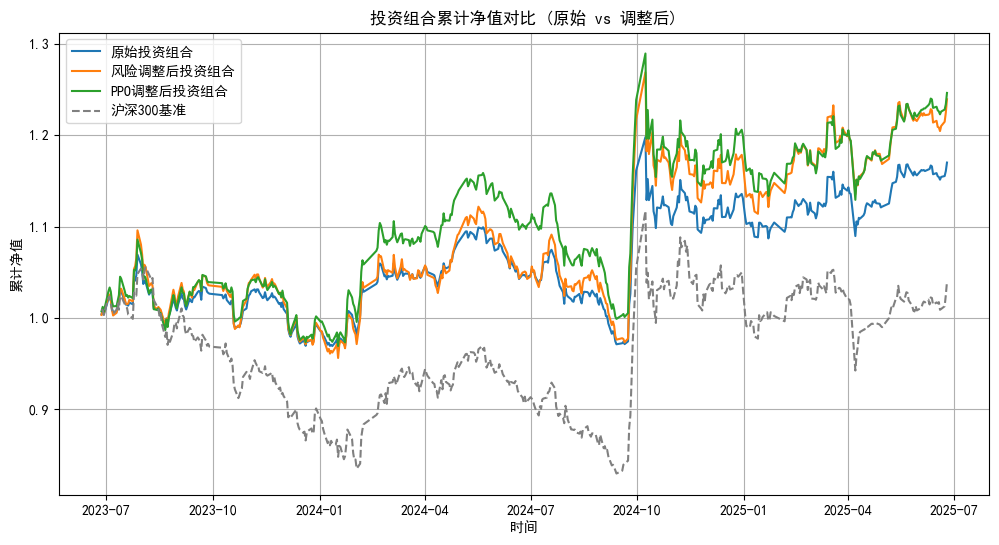

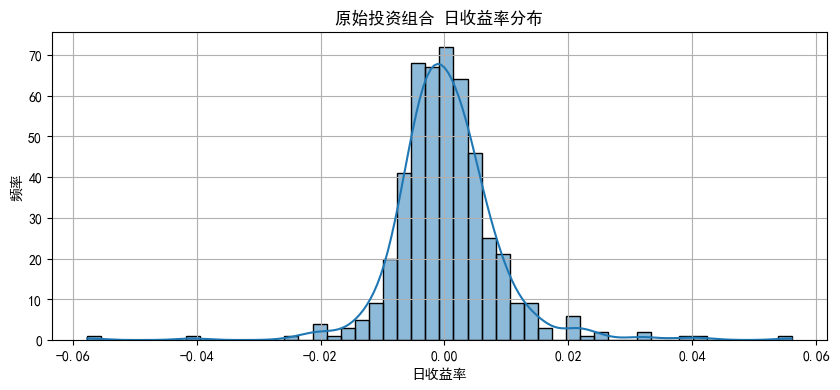

In [4]:
def normalize_weights(weights):
        total = sum(weights.values())
        return {k: v / total for k, v in weights.items()}

# 原始权重
original_weights = {
'601398' : 0.08,  # 贵州茅台 1
'600036' : 0.10,  # 工商银行
'002142' : 0.07,  # 招商银行
'600519' : 0.12,  # 恒瑞医药 1
'600887' : 0.06,  # 迈瑞医疗
'600276' : 0.10,  # 药明康德 
'002415' : 0.07,  # 宁波银行 1
'300760' : 0.09,  # 海康威视 1
'601857' : 0.06,  # 三一重工 1
'601088' : 0.03,  # 中国中车 1
}

risk_adjusted_weights = {
    '601398' : 0.09,  # 贵州茅台 1
    '600036' : 0.09,  # 工商银行
    '002142' : 0.06,  # 招商银行
    '600519' : 0.10,  # 恒瑞医药 1
    '600887' : 0.00,  # 迈瑞医疗
    '600276' : 0.08,  # 药明康德 
    '002415' : 0.05,  # 宁波银行 1
    '300760' : 0.08,  # 海康威视 1
    '601857' : 0.00,  # 三一重工 1
    '601088' : 0.03,  # 中国中车 1
    }
# 调整后的投资组合（降低银行/医药权重，增加消费/公用事业）
ppo_adjusted_weights = {
'601398' : 0.11,  # 贵州茅台 1
'600036' : 0.11,  # 工商银行
'002142' : 0.07,  # 招商银行
'600519' : 0.10,  # 恒瑞医药 1
'600887' : 0.05,  # 迈瑞医疗
'600276' : 0.13,  # 药明康德 
'002415' : 0.11,  # 宁波银行 1
'300760' : 0.12,  # 海康威视 1
'601857' : 0.11,  # 三一重工 1
'601088' : 0.07,  # 中国中车 1
}

# 归一化后权重
risk_normalized_weights = normalize_weights(risk_adjusted_weights)
ppo_normalized_weights = normalize_weights(ppo_adjusted_weights)
end_date = datetime.datetime.today().strftime("%Y%m%d")
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*2)).strftime("%Y%m%d")

# 评估原始投资组合
metrics_original, portfolio_rets_original, benchmark_rets = evaluate_portfolio(original_weights, start_date, end_date)

# 评估调整后的投资组合
risk_metrics_adjusted, risk_portfolio_rets_adjusted, _ = evaluate_portfolio(risk_normalized_weights, start_date, end_date)

ppo_metrics_adjusted, ppo_portfolio_rets_adjusted, _ = evaluate_portfolio(ppo_normalized_weights, start_date, end_date)
# 获取沪深300基准收益数据（作为单独的投资组合）
benchmark_weights = {"sh000300": 1.0}  # 沪深300作为单一资产
metrics_benchmark, portfolio_rets_benchmark, _ = evaluate_portfolio(benchmark_weights, start_date, end_date)


# 将两个投资组合的绩效指标整合到DataFrame中
comparison_df = pd.DataFrame({
    "原始": metrics_original,
    "风险调整": risk_metrics_adjusted,
    "PPO调整":ppo_metrics_adjusted,
    "沪深300基准": metrics_benchmark  # 新增沪深300基准列
}).T # 转置以便行是组合名称，列是指标

# 格式化输出，保持两位小数，百分比显示
formatted_comparison_df = comparison_df.copy()
for col in ['年化收益率', '年化波动率', '最大回撤', '年化超额收益率', '超额收益年化波动率', '超额收益最大回撤', 'VaR_5%', 'CVaR_5%', '累计收益', '年化累计收益']:
    formatted_comparison_df[col] = formatted_comparison_df[col].apply(lambda x: f"{x:.2%}")
for col in ['夏普比率', '信息比率', '偏度', '峰度', '相对基准月胜率']:
    formatted_comparison_df[col] = formatted_comparison_df[col].apply(lambda x: f"{x:.4f}")

# 可视化两个投资组合的累计净值对比
portfolio_to_plot = {
    "原始投资组合": portfolio_rets_original,
    "风险调整后投资组合":risk_portfolio_rets_adjusted,
    "PPO调整后投资组合": ppo_portfolio_rets_adjusted
}
plot_portfolio_performance(portfolio_to_plot, benchmark_rets, title="投资组合累计净值对比 (原始 vs 调整后)")


In [5]:
print("--- 投资组合绩效对比 ---")
formatted_comparison_df 

--- 投资组合绩效对比 ---


,年化收益率,年化波动率,夏普比率,索提诺比率,最大回撤,年化超额收益率,超额收益年化波动率,信息比率,相对基准月胜率,超额收益最大回撤,偏度,峰度,VaR_5%,CVaR_5%,累计收益,年化累计收益
原始,8.53%,13.75%,0.4455,0.665595,-11.67%,5.13%,9.12%,0.5628,0.5600,-13.17%,0.4200,10.1979,-1.06%,-1.76%,17.02%,9.55%
风险调整,11.83%,17.53%,0.5541,0.861505,-13.26%,8.93%,9.51%,0.9393,0.6400,-9.75%,0.5484,8.7379,-1.33%,-2.21%,23.96%,13.55%
PPO调整,12.16%,17.13%,0.5801,0.840107,-13.81%,9.21%,9.18%,1.0034,0.6000,-11.10%,0.2657,10.5354,-1.31%,-2.23%,24.65%,13.81%
沪深300基准,2.04%,18.42%,0.0382,0.056325,-21.42%,0.00%,0.00%,nan,0.0000,0.00%,0.5759,12.8578,-1.30%,-2.38%,3.95%,3.77%


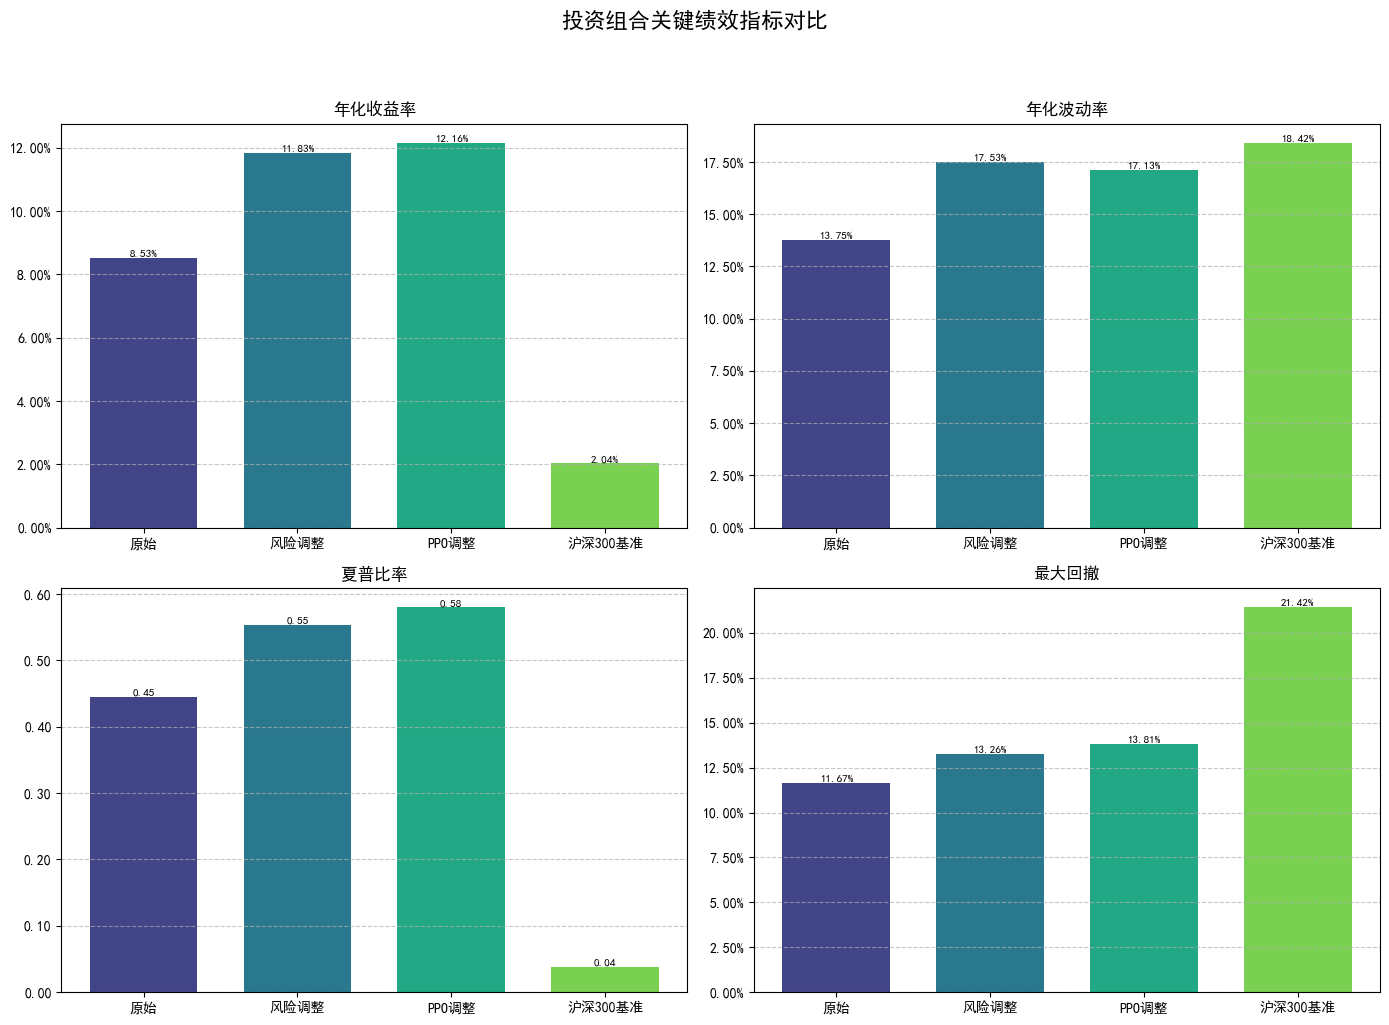

In [6]:
metrics_to_plot = ['年化收益率', '年化波动率', '夏普比率', '最大回撤']

# Set up plotting in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Changed to 2 rows, 2 columns
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

fig.suptitle('投资组合关键绩效指标对比', fontsize=16, y=1.02)

# Create a subplot for each metric
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # Note: Max drawdown is negative, we take its absolute value for comparison, or plot directly
    data = comparison_df[metric]
    
    # Apply absolute value for '最大回撤' only for plotting, if desired
    if metric == '最大回撤':
        data = abs(data) # Convert to positive for easier visualization as a "magnitude" of drawdown
        
    bars = ax.bar(comparison_df.index, data, width=0.7, color=sns.color_palette("viridis", len(comparison_df.index)))
    ax.set_title(metric) # Set title for each subplot
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set y-axis tick labels to percentage for relevant metrics
    if metric in ['年化收益率', '年化波动率', '最大回撤']:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
    else: # For Sharpe Ratio, keep it as float
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

    # Display values on the bars
    for bar in bars:
        yval = bar.get_height()
        if metric in ['年化收益率', '年化波动率', '最大回撤']:
            label = f'{yval:.2%}'
        else:
            label = f'{yval:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, label, ha='center', va='bottom', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect for suptitle
plt.show()

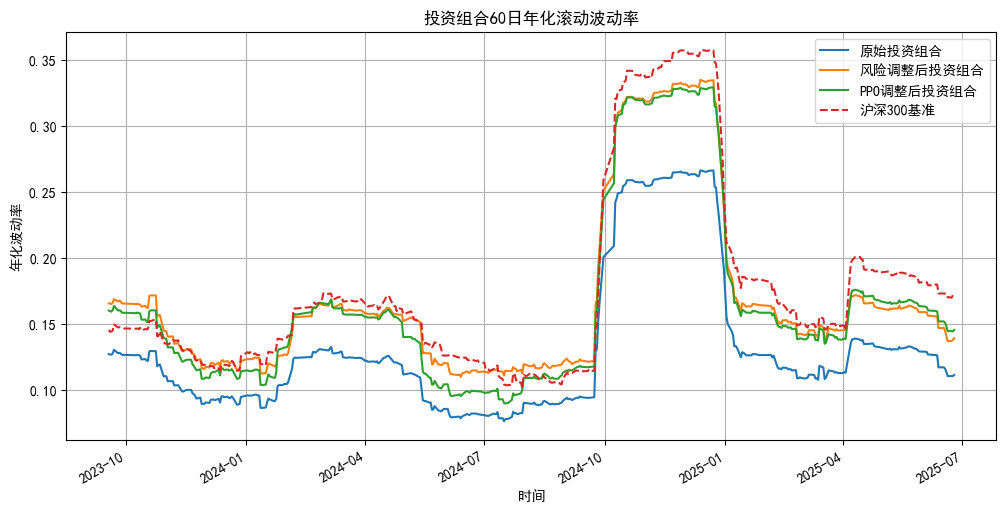

In [7]:
# 计算60日滚动波动率
rolling_vol = {}
for name, rets in portfolio_to_plot.items():
    # 年化滚动波动率
    rolling_vol[name] = rets.rolling(window=60).std() * np.sqrt(252)

# 单独计算基准的滚动波动率
rolling_vol["沪深300基准"] = benchmark_rets.rolling(window=60).std() * np.sqrt(252)

# 绘图
plt.figure(figsize=(12, 6))
for name, vol_series in rolling_vol.items():
    linestyle = '--' if name == "沪深300基准" else '-'
    vol_series.plot(label=name, linestyle=linestyle)

plt.title('投资组合60日年化滚动波动率')
plt.xlabel('时间')
plt.ylabel('年化波动率')
plt.legend()
plt.grid(True)
plt.show()

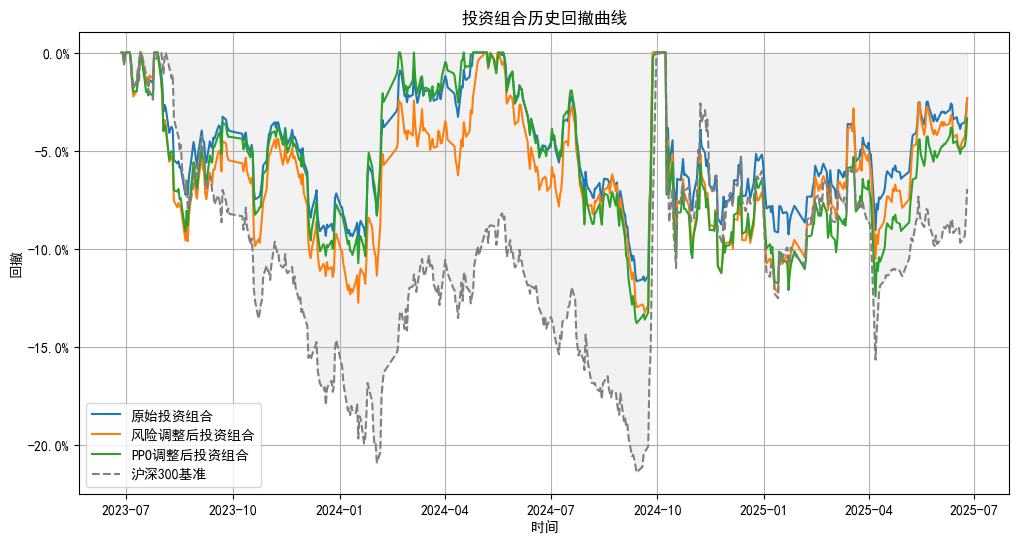

In [8]:
def plot_drawdowns(portfolio_returns_dict, benchmark_rets):
    plt.figure(figsize=(12, 6))

    # 绘制每个投资组合的回撤曲线
    for name, rets in portfolio_returns_dict.items():
        wealth_index = (1 + rets).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks) / previous_peaks
        plt.plot(drawdowns, label=name)

    # 绘制基准的回撤曲线
    bench_wealth = (1 + benchmark_rets).cumprod()
    bench_peaks = bench_wealth.cummax()
    bench_drawdowns = (bench_wealth - bench_peaks) / bench_peaks
    plt.plot(bench_drawdowns, label="沪深300基准", color='gray', linestyle='--')

    plt.title('投资组合历史回撤曲线')
    plt.xlabel('时间')
    plt.ylabel('回撤')
    # 将y轴格式化为百分比
    from matplotlib.ticker import PercentFormatter
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.legend()
    plt.grid(True)
    plt.fill_between(bench_drawdowns.index, bench_drawdowns, 0, alpha=0.1, color='gray') # 阴影突出显示回撤区域
    plt.show()

# 调用
plot_drawdowns(portfolio_to_plot, benchmark_rets)

C:\Users\叶巧妍\AppData\Local\Temp\ipykernel_12112\1083346007.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(label, (ann_vol[i], ann_ret[i]), textcoords="offset points", xytext=(0,10), ha='center')


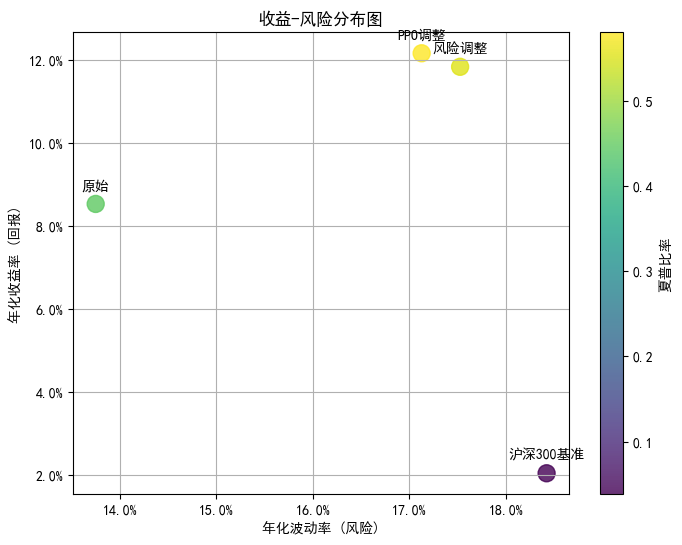

In [16]:
plt.figure(figsize=(8, 6))
# 从 comarison_df 中提取数据
ann_ret = comparison_df['年化收益率']
ann_vol = comparison_df['年化波动率']
labels = comparison_df.index

# 绘制散点图
scatter = plt.scatter(ann_vol, ann_ret, c=comparison_df['夏普比率'], cmap='viridis', s=150, alpha=0.8)
plt.colorbar(scatter, label='夏普比率')

# 为每个点添加标签
for i, label in enumerate(labels):
    plt.annotate(label, (ann_vol[i], ann_ret[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('收益-风险分布图')
plt.xlabel('年化波动率 (风险)')
plt.ylabel('年化收益率 (回报)')
# 将坐标轴格式化为百分比
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True)
plt.show() 

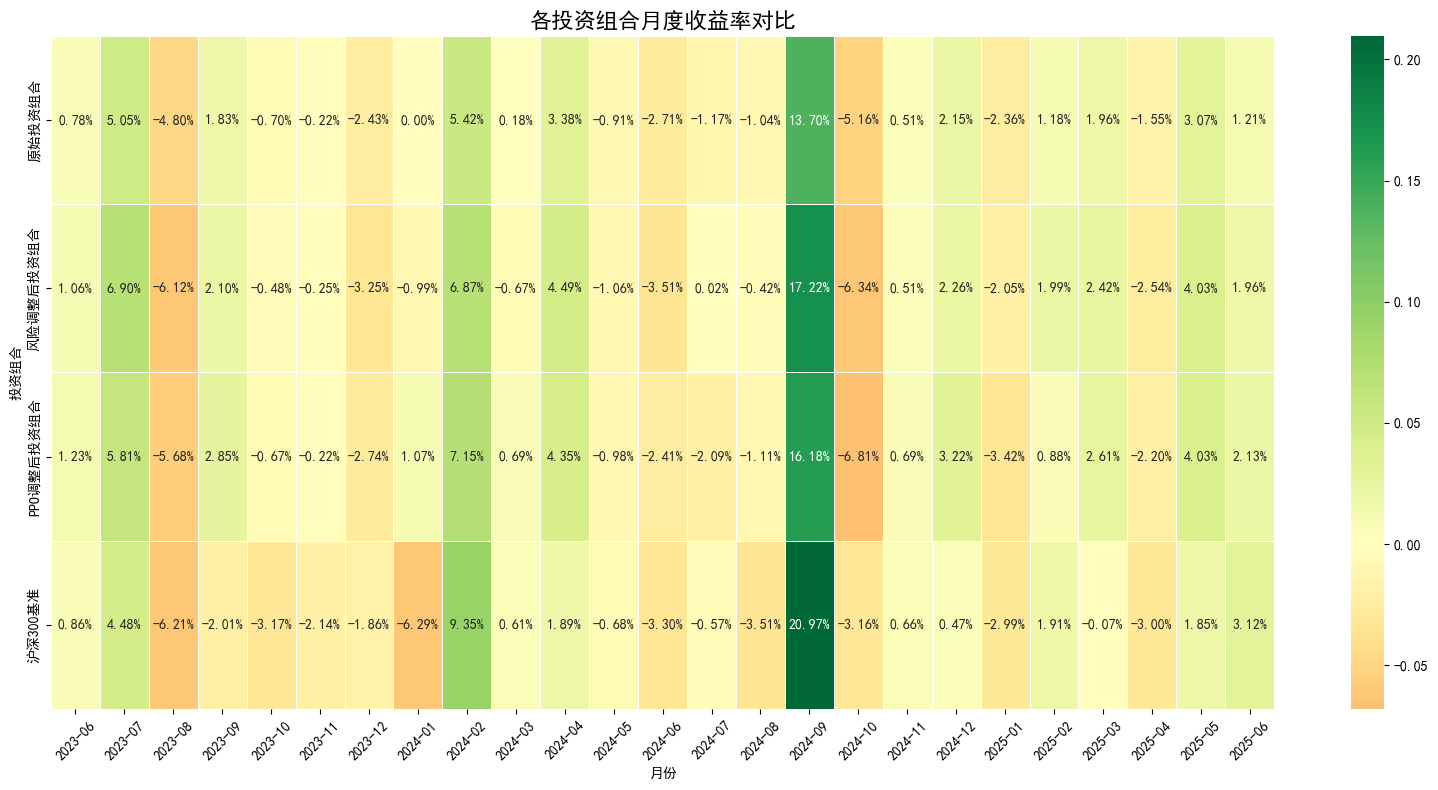

In [10]:
# 创建一个包含所有收益序列的DataFrame
all_returns_df = pd.DataFrame(portfolio_to_plot)
all_returns_df['沪深300基准'] = benchmark_rets

# 计算月度收益率
monthly_returns = all_returns_df.resample('ME').apply(lambda x: (1 + x).prod() - 1)
# 将索引格式化为年月
monthly_returns.index = monthly_returns.index.strftime('%Y-%m')

# 假设 monthly_returns 已经准备好

# 1. 增大图表宽度，例如从12增加到18
plt.figure(figsize=(16, 8)) 

# 2. 在 heatmap 函数中，使用 annot_kws 参数缩小字体
#    annot_kws={"size": 8} 表示将标注字体大小设置为8
sns.heatmap(
    monthly_returns.T, 
    annot=True, 
    fmt='.2%', 
    cmap='RdYlGn', 
    center=0, 
    linewidths=.5,
    annot_kws={"size": 10}  # <--- 关键修改：缩小标注字体
)

plt.title('各投资组合月度收益率对比', fontsize=16) # 也可以适当调大标题字体
plt.xlabel('月份')
plt.ylabel('投资组合')
plt.xticks(rotation=45) # 将x轴的标签倾斜45度，有时也能改善布局
plt.tight_layout() # 自动调整布局，防止标签被截断
plt.show() 

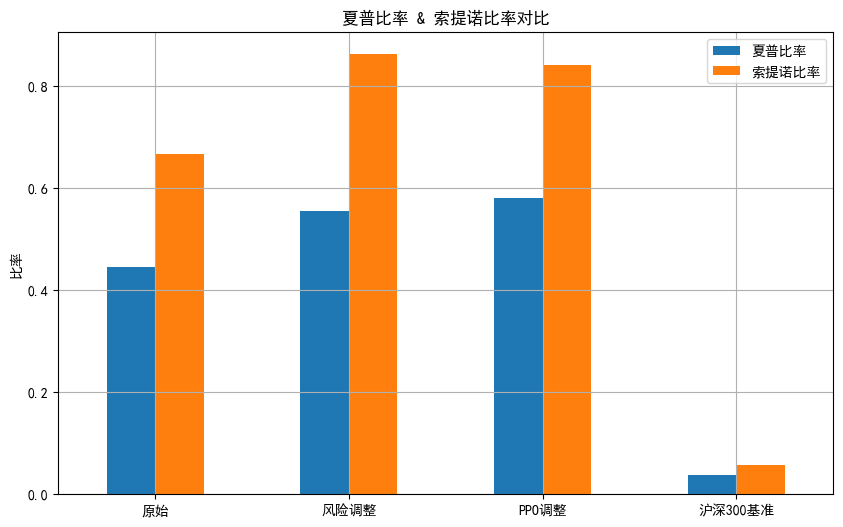

In [11]:
ratios = comparison_df[['夏普比率', '索提诺比率']].apply(pd.to_numeric, errors='coerce')

ratios.plot(kind='bar', figsize=(10, 6), grid=True)
plt.title('夏普比率 & 索提诺比率对比')
plt.ylabel('比率')
plt.xticks(rotation=0)
plt.legend(['夏普比率', '索提诺比率'])
plt.grid(True)
plt.show() 